# About

Calculate statistics for the GhostWrites dataset (which is the name used for the PrismAI dataset for the LREC paper).

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import re
import gc
import numpy as np
import pandas as pd

from pathlib import Path
from IPython.display import display, HTML
from luminar.detector import LuminarSequenceDetector
from luminar.utils.cuda import get_best_device
from luminar.sequence_classifier import LuminarSequence
from luminar.utils import LuminarSequenceTrainingConfig, ConvolutionalLayerSpec
from luminar.utils.visualization import visualize_detection
from data_hub.hub import DataHub
from datasets import DatasetDict, load_dataset
from collections import Counter

torch.cuda.empty_cache()
gc.collect()
if torch.cuda.is_available():
    with torch.cuda.device(torch.cuda.current_device()):
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [4]:
dataset = load_dataset("TheItCrOw/GhostWriter")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'domain', 'date', 'source', 'lang', 'label', 'agent', 'type'],
        num_rows: 382535
    })
    test: Dataset({
        features: ['id', 'text', 'domain', 'date', 'source', 'lang', 'label', 'agent', 'type'],
        num_rows: 109296
    })
    validation: Dataset({
        features: ['id', 'text', 'domain', 'date', 'source', 'lang', 'label', 'agent', 'type'],
        num_rows: 54648
    })
})


# Metrics

- **n_chars**  
  Total number of characters in the text, including whitespace and punctuation.  
  **Definition:** Count of all characters in the raw string.

- **n_chars_nospace**  
  Total number of characters excluding all whitespace characters.  
  **Definition:** Number of characters that are *not* spaces, tabs, or newlines.

- **n_words**  
  Number of tokens after whitespace splitting and removing leading/trailing punctuation.  
  **Definition:** Total count of valid tokens containing at least one alphanumeric character.

- **avg_word_len**  
  Average word length in characters. Returns zero if there are no words.  
  **Definition:** Sum of all token lengths divided by the number of tokens.

- **n_sents**  
  Estimated number of sentences based on splitting the text at `.`, `!`, or `?`.  
  **Definition:** Count of non-empty sentence segments (minimum 1 for any non-empty text).

- **n_punct**  
  Number of punctuation characters in the text.  
  **Definition:** Count of characters that are neither alphanumeric nor whitespace.

- **punct_ratio**  
  Ratio of punctuation characters to all non-space characters.  
  **Range:** 0–1 (0 if there are no non-space characters).

- **upper_ratio**  
  Ratio of uppercase letters to all non-space characters.  
  **Range:** 0–1 (0 if there are no non-space characters).

- **digit_ratio**  
  Ratio of numeric digits to all non-space characters.  
  **Range:** 0–1 (0 if there are no non-space characters).

- **url_count**  
  Number of URL-like substrings detected (matching `https?://...` or `www.`).  
  **Definition:** Count of regex matches for web addresses.

- **type_token_ratio**  
  Lexical diversity: proportion of unique words (lowercased) to total words.  
  **Range:** 0–1 — higher values indicate more diverse vocabulary.

- **hapax_ratio**  
  Proportion of words that appear exactly once (hapax legomena) in the text.  
  **Range:** 0–1 — higher values indicate more single-occurrence words.



In [5]:
RE_URL = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
RE_SENT_SPLIT = re.compile(r"[.!?]+")
# "Punctuation-like": any char that is not alphanumeric and not whitespace
RE_PUNCT_CHAR = re.compile(r"[^\w\s]", re.UNICODE)

def safe_div(n, d):
    return n / d if d else 0.0

def tokenize_words(text: str):
    """
    Very lightweight tokenizer: split on whitespace, strip surrounding punctuation.
    Keeps tokens with any alphanumeric character.
    """
    if not text:
        return []
    rough = text.split()
    tokens = []
    for tok in rough:
        # strip leading/trailing punctuation-like chars
        tok = re.sub(r"^\W+|\W+$", "", tok, flags=re.UNICODE)
        if any(ch.isalnum() for ch in tok):
            tokens.append(tok)
    return tokens

def sentence_count(text: str):
    if not text:
        return 0
    # Count non-empty fragments after splitting on sentence enders
    parts = [p for p in RE_SENT_SPLIT.split(text) if p.strip()]
    return max(1, len(parts))  # treat as at least 1 sentence if text exists

def text_metrics(text: str):
    """
    Compute metrics for a single text. No external dependencies.
    """
    if text is None:
        text = ""
    n_chars = len(text)
    n_chars_nospace = sum(1 for c in text if not c.isspace())

    # Words
    words = tokenize_words(text)
    n_words = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if n_words else 0.0

    # Sentences
    n_sents = sentence_count(text)

    # Punctuation
    n_punct = len(RE_PUNCT_CHAR.findall(text))
    punct_ratio = safe_div(n_punct, n_chars_nospace)

    # Character-category ratios
    n_upper = sum(1 for c in text if c.isupper())
    n_digit = sum(1 for c in text if c.isdigit())
    upper_ratio = safe_div(n_upper, n_chars_nospace)
    digit_ratio = safe_div(n_digit, n_chars_nospace)

    # URLs
    url_count = len(RE_URL.findall(text))

    # Lexical variety
    # Lowercased for types; you can switch off lowercasing if you prefer case-sensitive
    lc_words = [w.lower() for w in words]
    unique_count = len(set(lc_words))
    ttr = safe_div(unique_count, n_words)
    freqs = Counter(lc_words)
    hapax = sum(1 for _, f in freqs.items() if f == 1)
    hapax_ratio = safe_div(hapax, n_words)

    return {
        "n_chars": n_chars,
        "n_chars_nospace": n_chars_nospace,
        "n_words": n_words,
        "avg_word_len": float(avg_word_len),
        "n_sents": n_sents,
        "n_punct": n_punct,
        "punct_ratio": float(punct_ratio),
        "upper_ratio": float(upper_ratio),
        "digit_ratio": float(digit_ratio),
        "url_count": url_count,
        "type_token_ratio": float(ttr),
        "hapax_ratio": float(hapax_ratio),
    }

def metrics_map_fn(batch):
    texts = batch["text"]
    out = {
        "n_chars": [],
        "n_chars_nospace": [],
        "n_words": [],
        "avg_word_len": [],
        "n_sents": [],
        "n_punct": [],
        "punct_ratio": [],
        "upper_ratio": [],
        "digit_ratio": [],
        "url_count": [],
        "type_token_ratio": [],
        "hapax_ratio": [],
    }
    for t in texts:
        m = text_metrics(t)
        for k in out:
            out[k].append(m[k])
    return out

def enrich_with_metrics(dataset_dict: DatasetDict, batch_size: int = 1000):
    """
    Returns a dict of enriched splits AND a single concatenated pandas DataFrame
    with an added 'split' column.
    """
    enriched = {}
    frames = []
    for split_name, ds in dataset_dict.items():
        ds_enriched = ds.map(
            metrics_map_fn,
            batched=True,
            batch_size=batch_size,
            num_proc=8,
            desc=f"Computing metrics for split '{split_name}'",
        )
        enriched[split_name] = ds_enriched
        df = ds_enriched.to_pandas()
        df.insert(0, "split", split_name)
        frames.append(df)
    all_df = pd.concat(frames, ignore_index=True)
    return enriched, all_df

METRIC_COLUMNS = [
    "n_chars",
    "n_chars_nospace",
    "n_words",
    "avg_word_len",
    "n_sents",
    "n_punct",
    "punct_ratio",
    "upper_ratio",
    "digit_ratio",
    "url_count",
    "type_token_ratio",
    "hapax_ratio",
]

def aggregate_metrics(df: pd.DataFrame, groupby_cols=None):
    """
    Compute mean and std for METRIC_COLUMNS.
    If groupby_cols is None or empty, returns overall (single row) aggregation.
    """
    if not groupby_cols:
        agg = df[METRIC_COLUMNS].agg(["mean", "std"]).T.reset_index()
        agg.columns = ["metric", "mean", "std"]
        return agg

    grouped = df.groupby(groupby_cols, dropna=False)[METRIC_COLUMNS]
    agg = grouped.agg(["mean", "std"]).reset_index()

    # Flatten multiindex columns: (metric, stat) -> metric_stat
    agg.columns = [
        "_".join(col).strip("_") if isinstance(col, tuple) else col
        for col in agg.columns.to_flat_index()
    ]
    return agg

In [6]:
enriched_splits, all_df = enrich_with_metrics(dataset, batch_size=10000)

# Full-dataset
metrics_overall = aggregate_metrics(all_df, groupby_cols=None)

# Per split
metrics_by_split = aggregate_metrics(all_df, groupby_cols=["split"])

# Per domain
metrics_by_domain = aggregate_metrics(all_df, groupby_cols=["domain"])

# Per agent
metrics_by_agent = aggregate_metrics(all_df, groupby_cols=["agent"])

# Per label (ai / human)
metrics_by_label = aggregate_metrics(all_df, groupby_cols=["label"])

# Full breakdown: split × domain × agent × label
metrics_full_breakdown = aggregate_metrics(
    all_df, groupby_cols=["split", "domain", "agent", "label"]
)

Computing metrics for split 'train' (num_proc=8):   0%|          | 0/382535 [00:00<?, ? examples/s]

Computing metrics for split 'test' (num_proc=8):   0%|          | 0/109296 [00:00<?, ? examples/s]

Computing metrics for split 'validation' (num_proc=8):   0%|          | 0/54648 [00:00<?, ? examples/s]

In [7]:
print("=== Overall ===")
print(metrics_overall.head(20).to_string(index=False))

print("\n=== By Split (head) ===")
print(metrics_by_split.head(20).to_string(index=False))

print("\n=== By Domain (head) ===")
print(metrics_by_domain.head(20).to_string(index=False))

print("\n=== By Agent (head) ===")
print(metrics_by_agent.head(20).to_string(index=False))

print("\n=== By Label (head) ===")
print(metrics_by_label.head(20).to_string(index=False))

print("\n=== Full Breakdown (head) ===")
print(metrics_full_breakdown.head(10).to_string(index=False))

=== Overall ===
          metric        mean          std
         n_chars 5958.878433 12659.594284
 n_chars_nospace 4975.612821 10462.478643
         n_words  966.110830  2146.040596
    avg_word_len    5.191415     1.241206
         n_sents   68.732844   187.441193
         n_punct  239.597809   812.446803
     punct_ratio    0.034614     0.021600
     upper_ratio    0.036981     0.029117
     digit_ratio    0.007234     0.015153
       url_count    0.104472     1.662064
type_token_ratio    0.539854     0.161527
     hapax_ratio    0.397780     0.169744

=== By Split (head) ===
     split  n_chars_mean  n_chars_std  n_chars_nospace_mean  n_chars_nospace_std  n_words_mean  n_words_std  avg_word_len_mean  avg_word_len_std  n_sents_mean  n_sents_std  n_punct_mean  n_punct_std  punct_ratio_mean  punct_ratio_std  upper_ratio_mean  upper_ratio_std  digit_ratio_mean  digit_ratio_std  url_count_mean  url_count_std  type_token_ratio_mean  type_token_ratio_std  hapax_ratio_mean  hapax_ratio_st

In [8]:
import math
import pathlib
import matplotlib.pyplot as plt

In [9]:
def set_paper_style(base_fontsize=9, use_latex=False):
    """
    A minimal, LaTeX-friendly style without external dependencies.
    If use_latex=True and your environment has LaTeX installed, text will use LaTeX.
    Otherwise we fall back to Computer Modern via mathtext for a similar look.
    """
    plt.rcParams.update({
        "figure.autolayout": False,      # we'll call tight_layout() explicitly
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize,
        "axes.labelsize": base_fontsize,
        "xtick.labelsize": base_fontsize-1,
        "ytick.labelsize": base_fontsize-1,
        "legend.fontsize": base_fontsize-1,
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "text.usetex": use_latex,        # set to True only if LaTeX is installed
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
    })

def fig_size(column="one", ratio=0.62):
    """
    Return (width, height) in inches for one- or two-column figures.
    ratio controls height = width * ratio (golden-ish default).
    """
    if column == "one":
        width = 2.7  # inches (typical one-column width)
    elif column == "two":
        width = 4.5  # inches (typical two-column width)
    else:
        width = float(column)  # allow custom widths
    return (width, max(1.6, width * ratio))

def save_fig(fig, out_dir, filename_stem):
    # Right now, not sure if I want to save them physically.
    # return 
    out_dir = pathlib.Path("../figures/dataset-statistics/ghostwriter/")
    out_dir.mkdir(parents=True, exist_ok=True)
    pdf_path = out_dir / f"{filename_stem}.pdf"
    png_path = out_dir / f"{filename_stem}.png"
    fig.tight_layout()
    #fig.savefig(pdf_path, bbox_inches="tight")
    fig.savefig(png_path, bbox_inches="tight")
    print(f"Saved: {pdf_path} and {png_path}")

def prettify_metric_name(name: str) -> str:
    mapping = {
        "n_chars": "Characters",
        "n_chars_nospace": "Characters (no space)",
        "n_words": "Words",
        "avg_word_len": "Avg. word length",
        "n_sents": "Sentences",
        "n_punct": "Punctuation",
        "punct_ratio": "Punctuation ratio",
        "upper_ratio": "Uppercase ratio",
        "digit_ratio": "Digit ratio",
        "url_count": "URLs",
        "type_token_ratio": "Type–Token Ratio",
        "hapax_ratio": "Hapax ratio",
    }
    return mapping.get(name, name.replace("_", " ").title())

def metric_columns_from_agg(df: pd.DataFrame):
    """
    Detect metric mean/std columns from aggregated frames like:
    n_words_mean, n_words_std, etc. Returns list of (metric, mean_col, std_col).
    """
    pairs = []
    for col in df.columns:
        if col.endswith("_mean"):
            metric = col[:-5]
            std_col = f"{metric}_std"
            pairs.append((metric, col, std_col if std_col in df.columns else None))
    return pairs

In [ ]:
domain_mappings = {
    "arxiv_papers": "arXiv",
    "blog_authorship_corpus": "Blogs",
    "bundestag": "Bundestag",
    "cnn_news": "CNN",
    "euro_court_cases": "ECHR",
    "gutenberg": "Gutenberg",
    "house_of_commons": "HoC",
    "spiegel_articles": "Spiegel",
    "student_essays": "Essays",
}

label_mappings = {
    0: "Human",
    1: "AI",
    2: "Fusion",
}

def plot_group_metric_bar(df: pd.DataFrame, group_col: str, metric: str,
                          out_dir="figures", width="one", top_n=None, height=None,
                          title=None, filename_stem=None):
    """
    df: aggregated frame with columns like f"{metric}_mean" and optionally f"{metric}_std"
    group_col: e.g., 'split', 'domain', 'agent', 'label'
    top_n: if provided, plot only top_n groups by mean
    """
    mean_col = f"{metric}_mean"
    std_col  = f"{metric}_std" if f"{metric}_std" in df.columns else None
    assert mean_col in df.columns, f"{mean_col} not found in df"

    d = df[[group_col, mean_col] + ([std_col] if std_col else [])].copy()
    d = d.sort_values(mean_col, ascending=False)
    if top_n:
        d = d.head(top_n)

    set_paper_style()
    w, h = fig_size(width, ratio=0.55 if group_col in {"domain", "agent"} and len(d) > 8 else 0.62)
    if height is not None:
        h = height
    fig, ax = plt.subplots(figsize=(w, h))

    bar_color = "#4790cc"
    error_kw = dict(elinewidth=0.6, ecolor="#636363", capsize=2)

    if group_col == "domain":
        d["label"] = d[group_col].map(domain_mappings)
    elif group_col == "label":
        d["label"] = d[group_col].map(label_mappings)
    else:
        d["label"] = d[group_col].astype(str)

    d = d.sort_values("label", ascending=True)

    y = np.arange(len(d))
    means = d[mean_col].values
    y_labels = d["label"].values

    ax.barh(
        y, means,
        xerr=d[std_col].values if std_col else None,
        height=0.65,
        color=bar_color,
        edgecolor="black",
        linewidth=0.6,
        error_kw=error_kw
    )

    ax.set_yticks(y)
    ax.set_yticklabels(y_labels, fontstyle='italic')
    ax.invert_yaxis()

    xlabel = f"{prettify_metric_name(metric)} (mean{' ± SD' if std_col else ''})"
    ax.set_xlabel(xlabel, fontstyle='italic', fontsize=9)

    if title:
        ax.set_title(title, fontweight='bold')

    if np.nanmin(means) > 0:
        ax.set_xlim(left=0)

    fname = filename_stem or f"{group_col}_{metric}_bar"
    save_fig(fig, out_dir, fname)
    
KEY_METRICS = [
    "n_words",
    "avg_word_len",
    "n_sents",
    "punct_ratio",
    "type_token_ratio",
    "hapax_ratio",
]

Saved: ../figures/dataset-statistics/ghostwriter/split_n_words.pdf and ../figures/dataset-statistics/ghostwriter/split_n_words.png
Saved: ../figures/dataset-statistics/ghostwriter/split_avg_word_len.pdf and ../figures/dataset-statistics/ghostwriter/split_avg_word_len.png
Saved: ../figures/dataset-statistics/ghostwriter/split_n_sents.pdf and ../figures/dataset-statistics/ghostwriter/split_n_sents.png
Saved: ../figures/dataset-statistics/ghostwriter/split_punct_ratio.pdf and ../figures/dataset-statistics/ghostwriter/split_punct_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/split_type_token_ratio.pdf and ../figures/dataset-statistics/ghostwriter/split_type_token_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/split_hapax_ratio.pdf and ../figures/dataset-statistics/ghostwriter/split_hapax_ratio.png


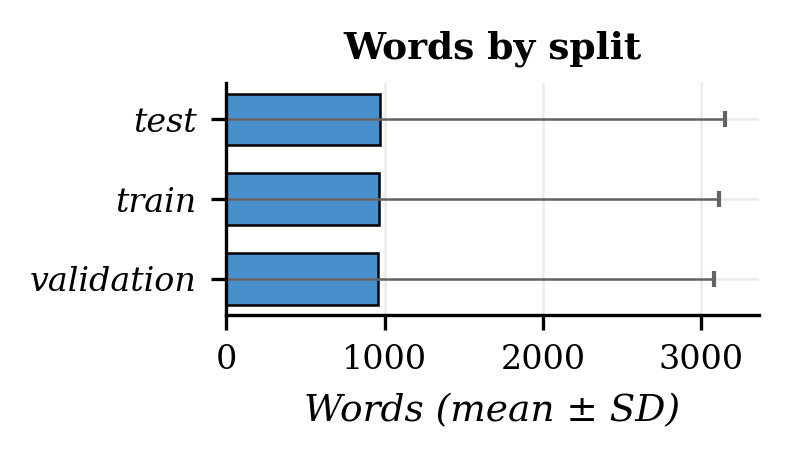

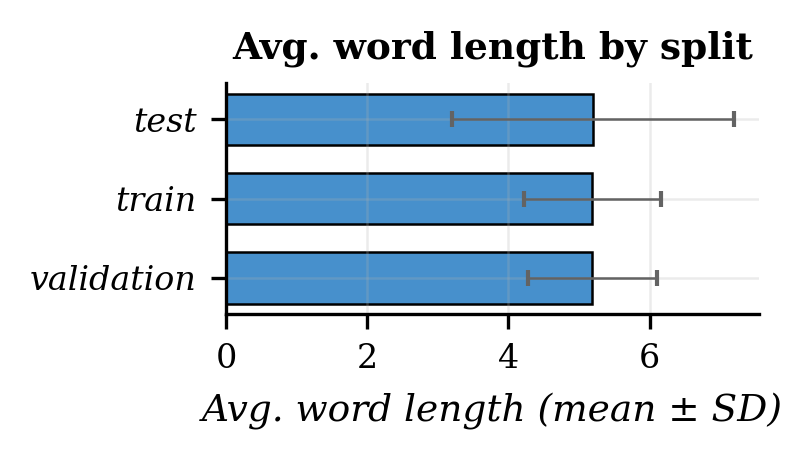

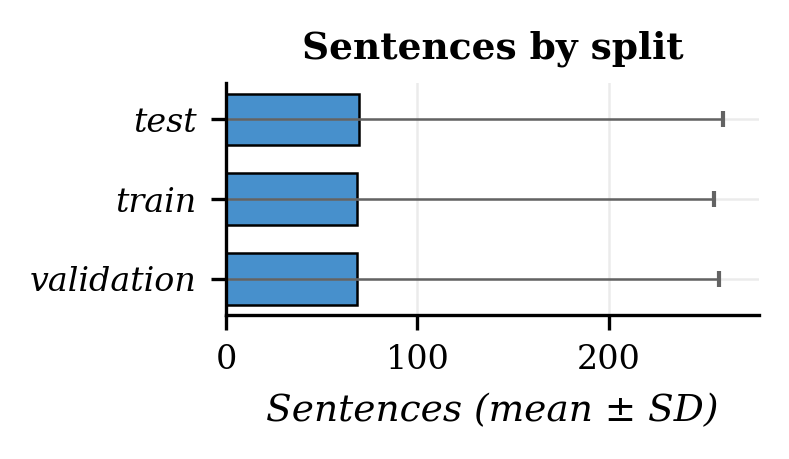

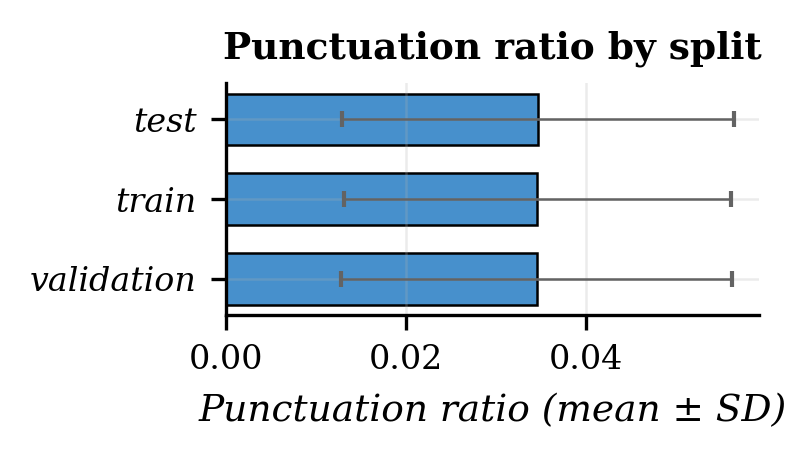

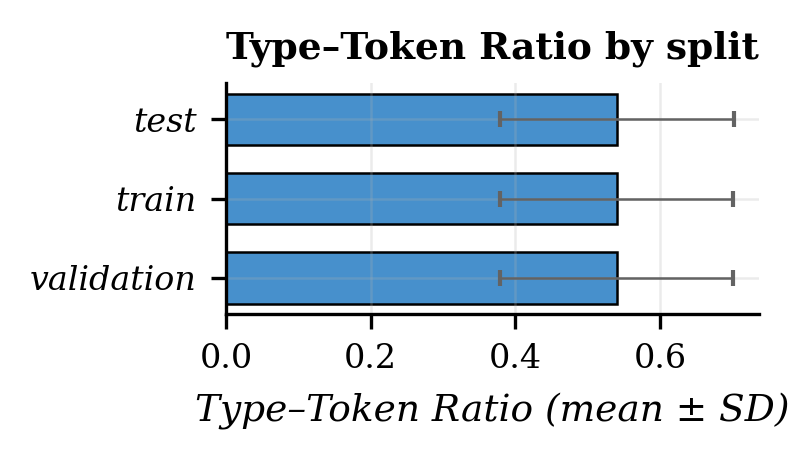

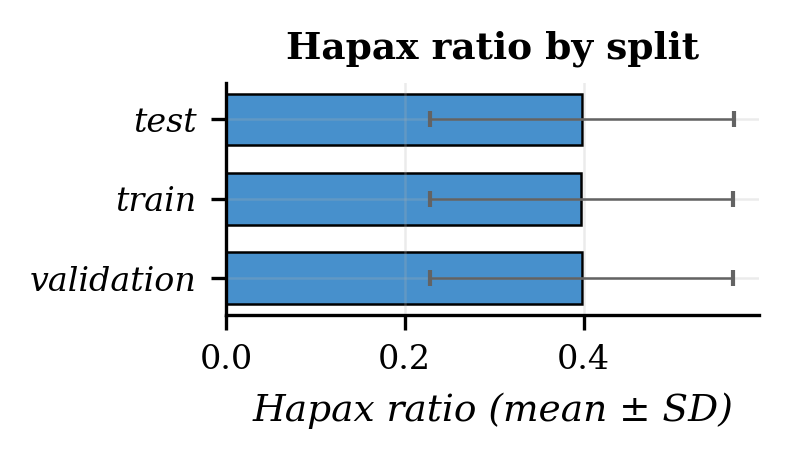

In [23]:
# 3.2 By Split
for m in KEY_METRICS:
    if f"{m}_mean" in metrics_by_split.columns:
        plot_group_metric_bar(
            metrics_by_split, "split", m,
            out_dir="figures",
            height=1.6,
            title=f"{prettify_metric_name(m)} by split",
            filename_stem=f"split_{m}"
        )

Saved: ../figures/dataset-statistics/ghostwriter/domain_n_words.pdf and ../figures/dataset-statistics/ghostwriter/domain_n_words.png
Saved: ../figures/dataset-statistics/ghostwriter/domain_avg_word_len.pdf and ../figures/dataset-statistics/ghostwriter/domain_avg_word_len.png
Saved: ../figures/dataset-statistics/ghostwriter/domain_n_sents.pdf and ../figures/dataset-statistics/ghostwriter/domain_n_sents.png
Saved: ../figures/dataset-statistics/ghostwriter/domain_punct_ratio.pdf and ../figures/dataset-statistics/ghostwriter/domain_punct_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/domain_type_token_ratio.pdf and ../figures/dataset-statistics/ghostwriter/domain_type_token_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/domain_hapax_ratio.pdf and ../figures/dataset-statistics/ghostwriter/domain_hapax_ratio.png


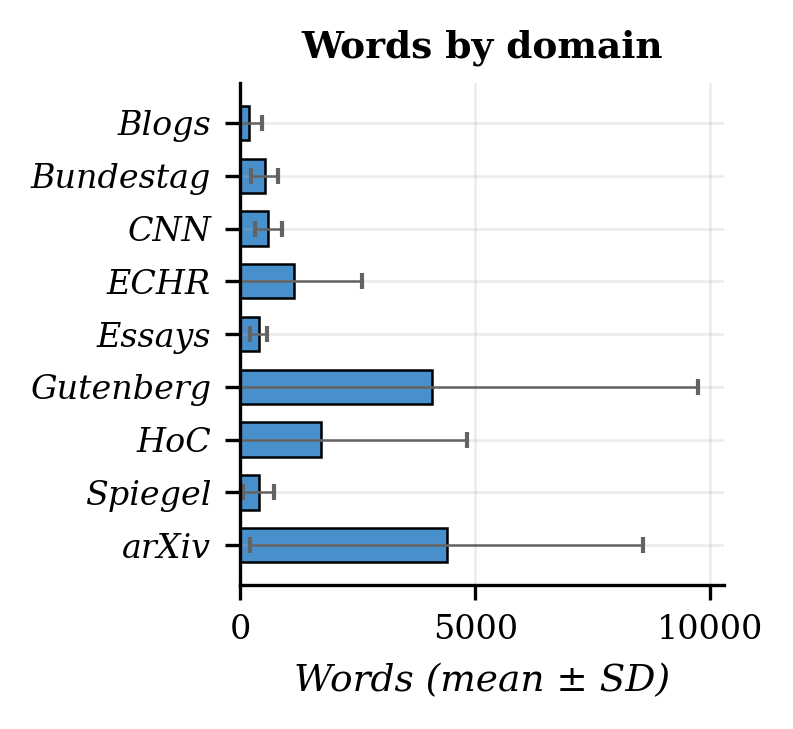

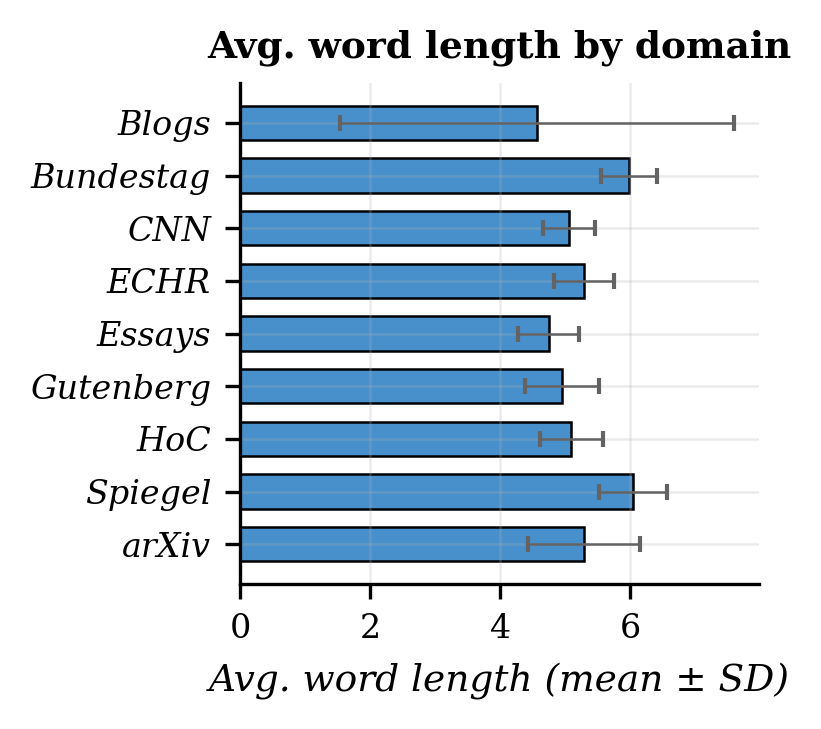

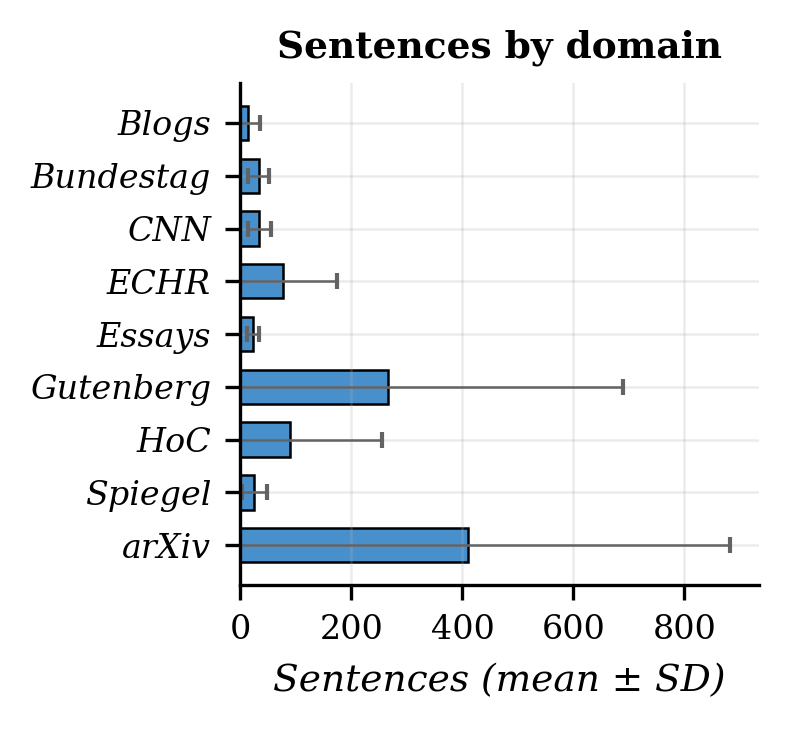

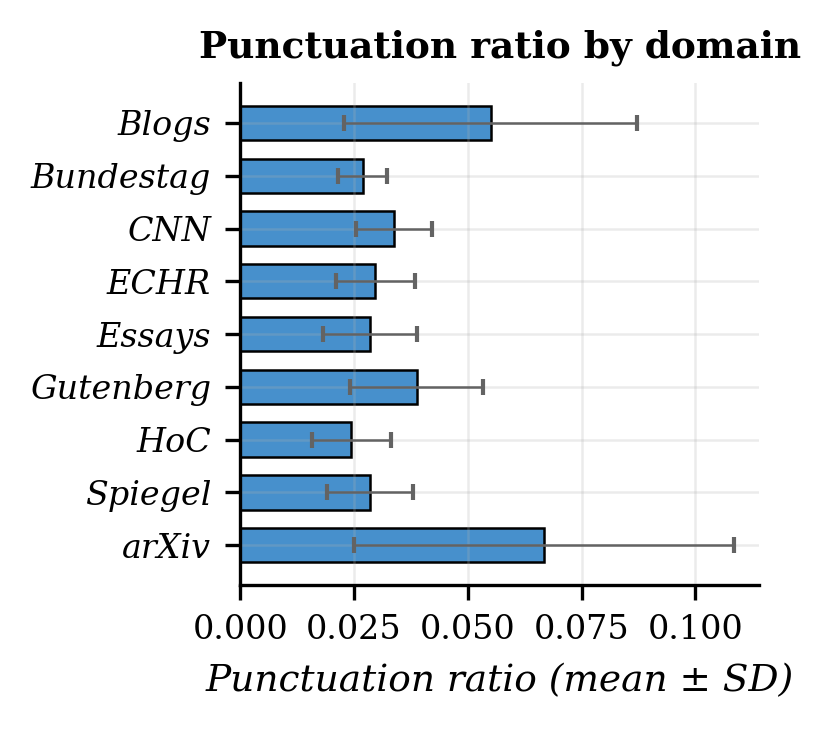

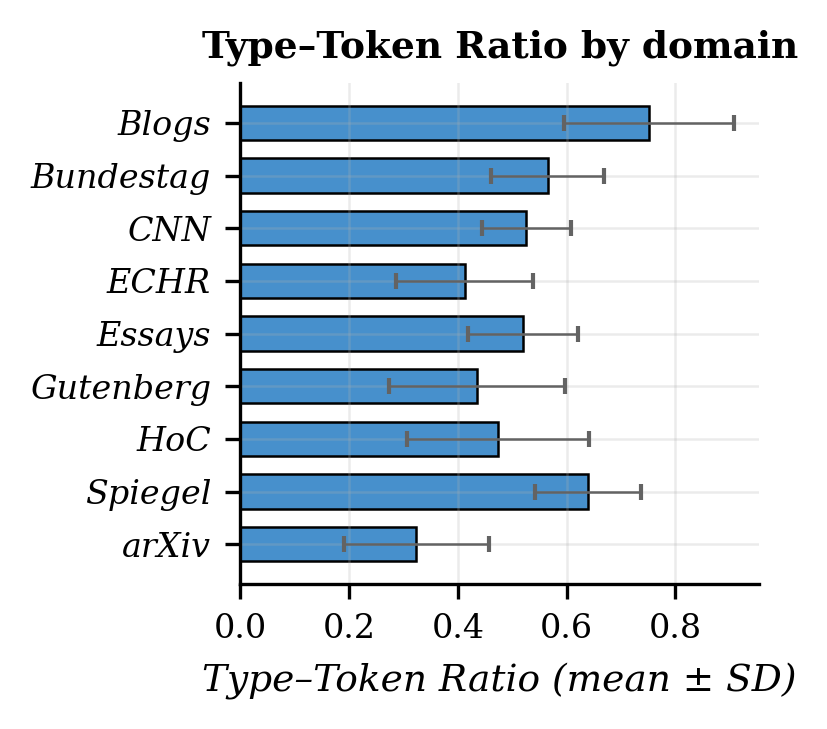

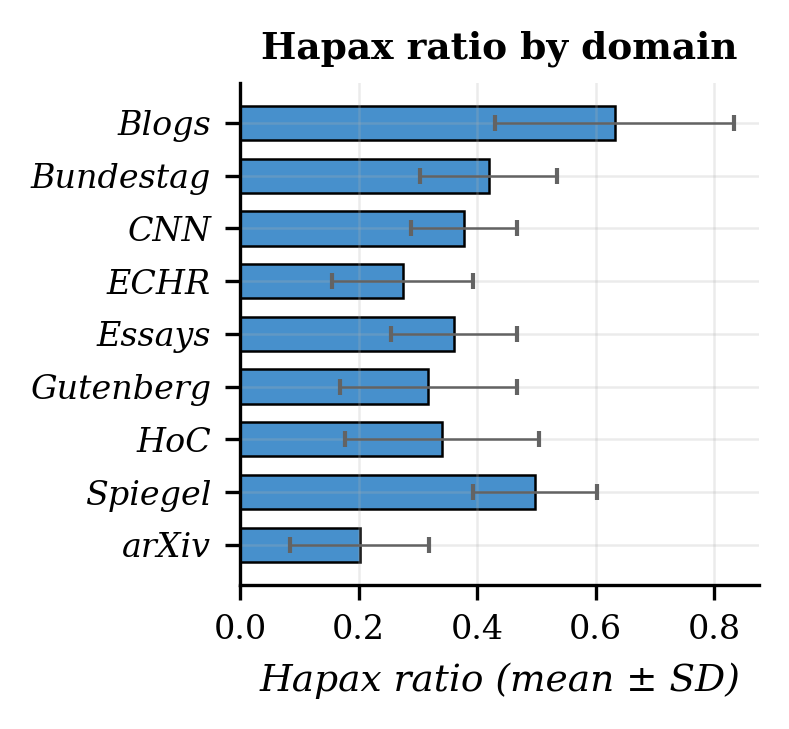

In [24]:
# 3.3 By Domain
for m in KEY_METRICS:
    if f"{m}_mean" in metrics_by_domain.columns:
        plot_group_metric_bar(
            metrics_by_domain, "domain", m,
            out_dir="figures",
            height=2.5,
            width="one",         # domains tend to be many; use wider figure
            title=f"{prettify_metric_name(m)} by domain",
            filename_stem=f"domain_{m}"
        )

Saved: ../figures/dataset-statistics/ghostwriter/agent_n_words.pdf and ../figures/dataset-statistics/ghostwriter/agent_n_words.png
Saved: ../figures/dataset-statistics/ghostwriter/agent_avg_word_len.pdf and ../figures/dataset-statistics/ghostwriter/agent_avg_word_len.png
Saved: ../figures/dataset-statistics/ghostwriter/agent_n_sents.pdf and ../figures/dataset-statistics/ghostwriter/agent_n_sents.png
Saved: ../figures/dataset-statistics/ghostwriter/agent_punct_ratio.pdf and ../figures/dataset-statistics/ghostwriter/agent_punct_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/agent_type_token_ratio.pdf and ../figures/dataset-statistics/ghostwriter/agent_type_token_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/agent_hapax_ratio.pdf and ../figures/dataset-statistics/ghostwriter/agent_hapax_ratio.png


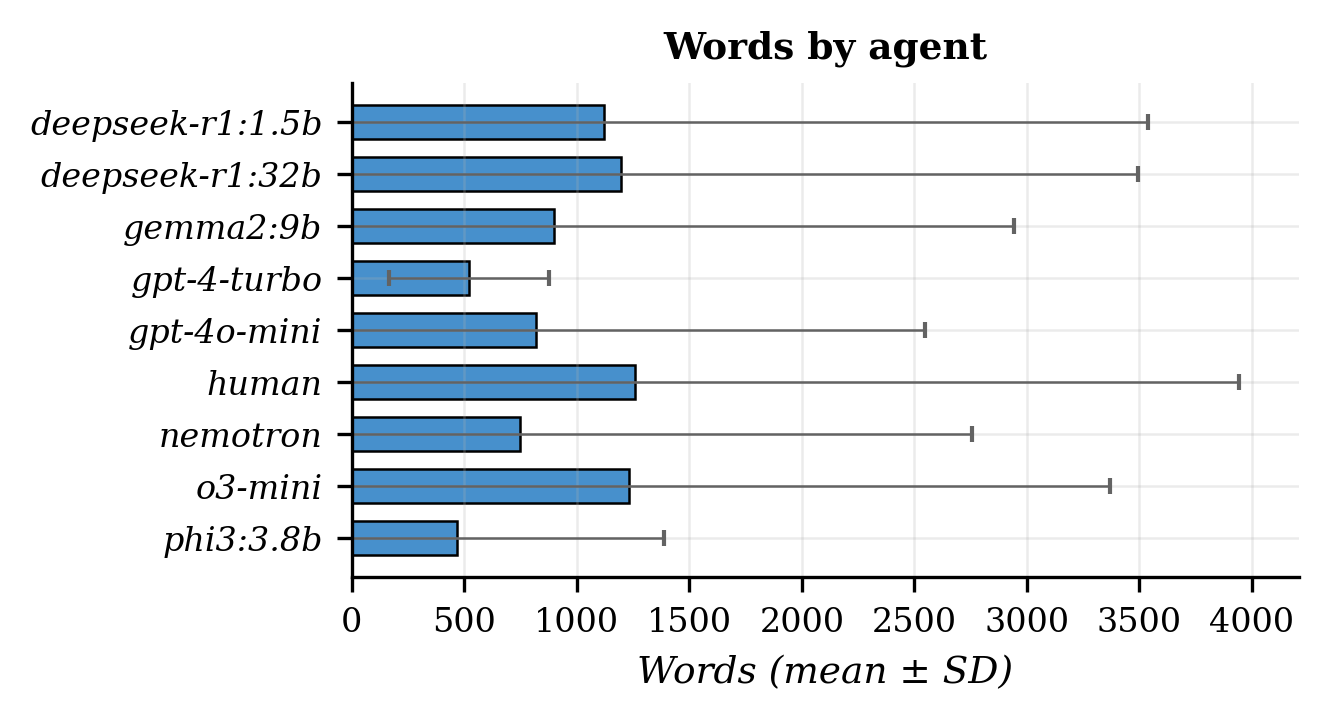

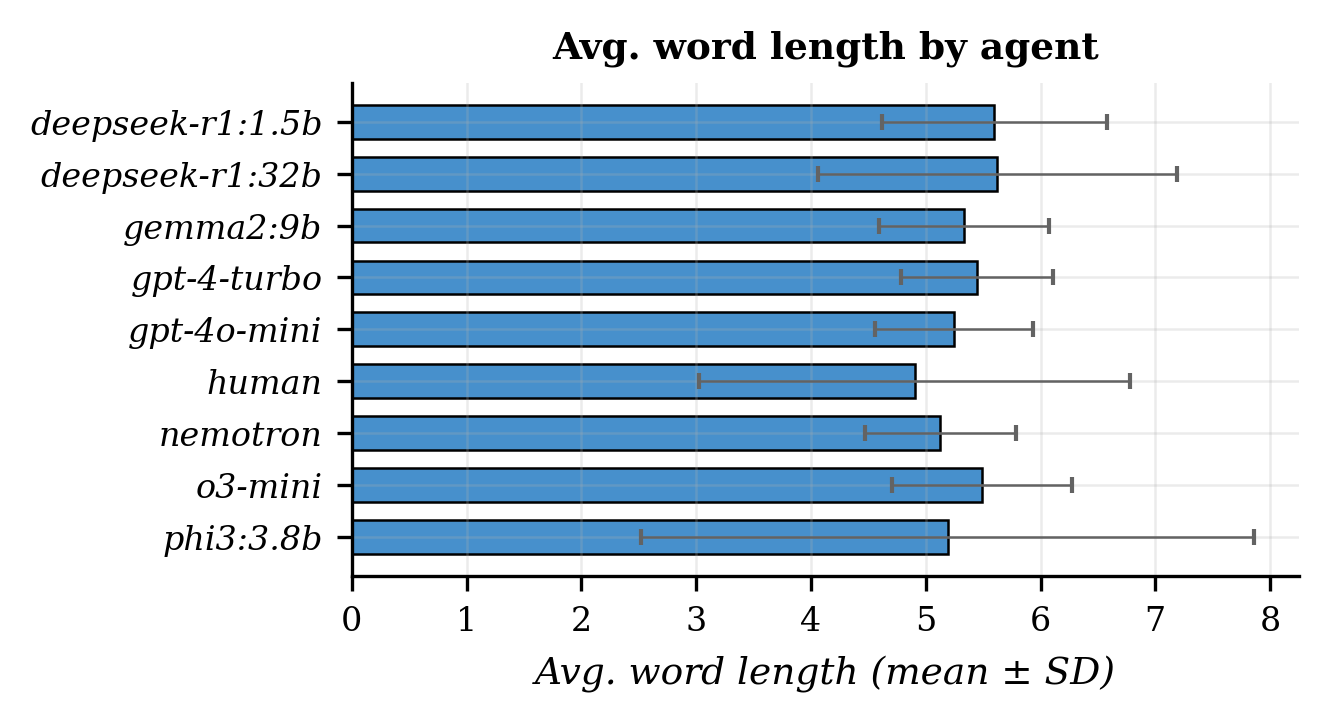

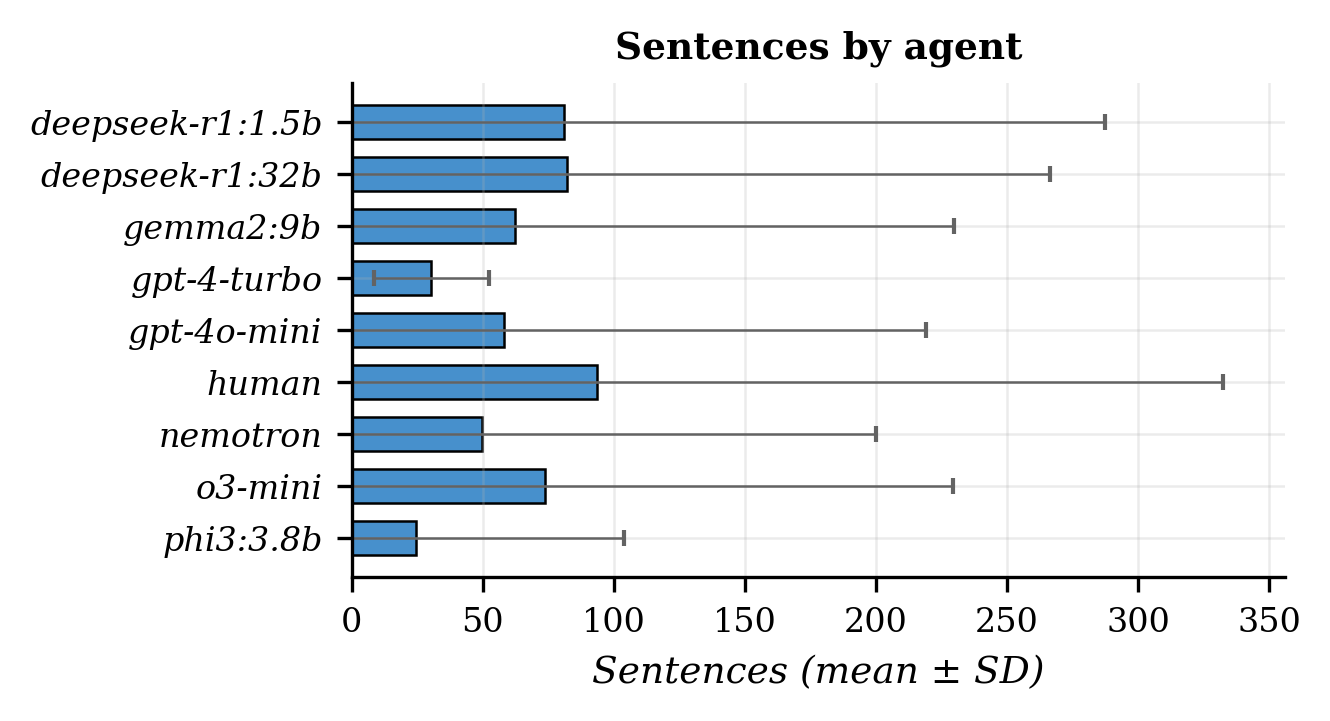

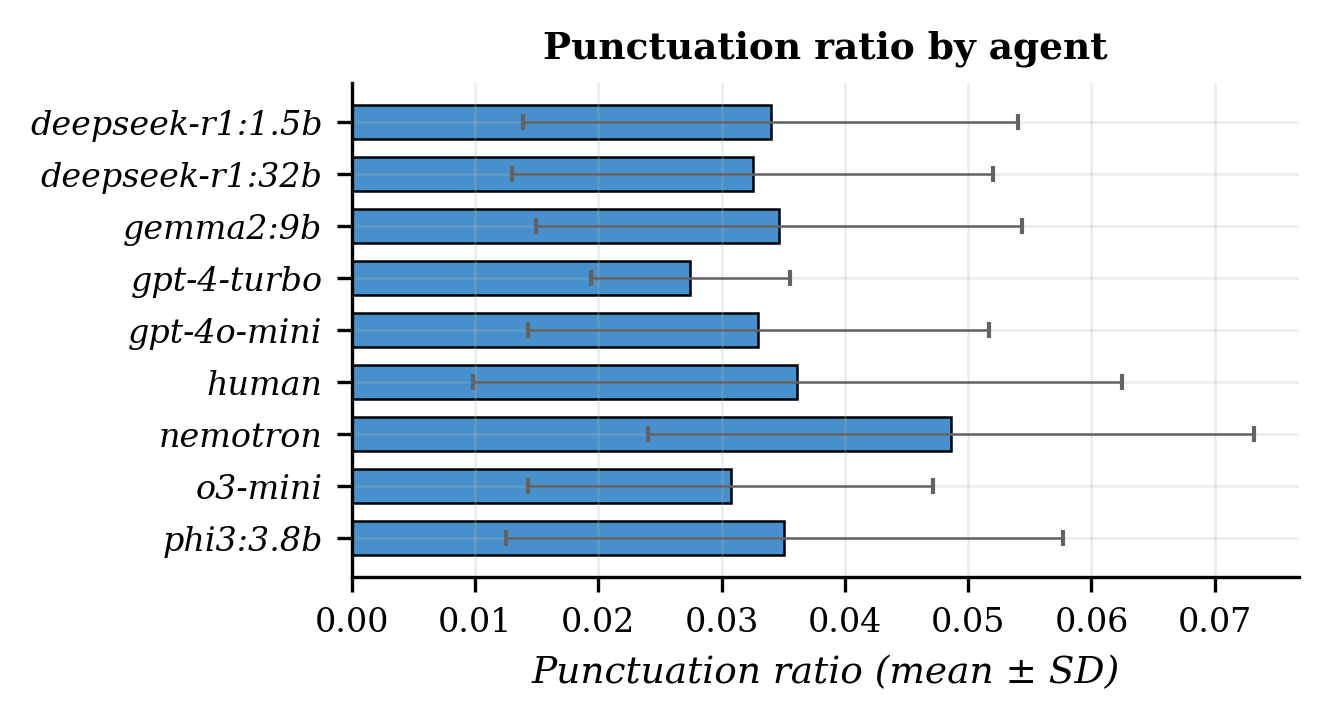

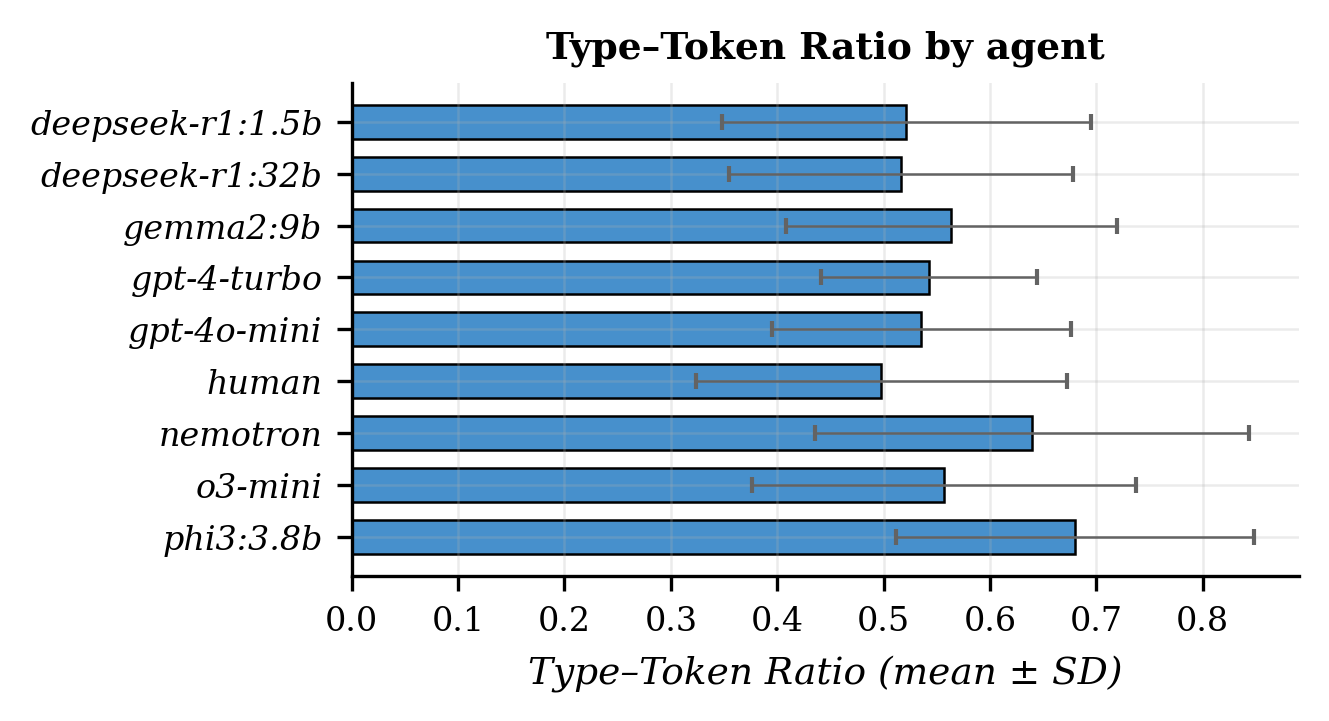

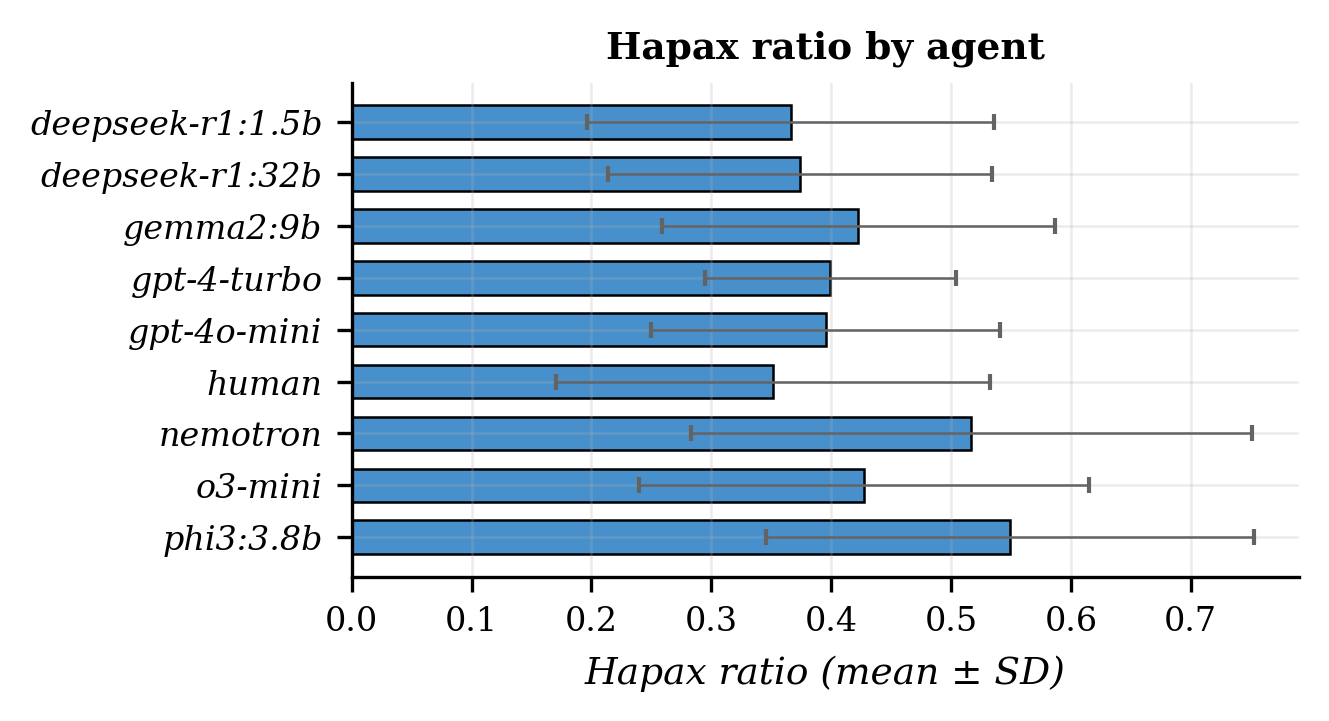

In [25]:
# 3.4 By Agent (all agents; horizontal bar works nicely)
for m in KEY_METRICS:
    if f"{m}_mean" in metrics_by_agent.columns:
        plot_group_metric_bar(
            metrics_by_agent, "agent", m,
            out_dir="figures",
            width="two",
            title=f"{prettify_metric_name(m)} by agent",
            filename_stem=f"agent_{m}"
        )

Saved: ../figures/dataset-statistics/ghostwriter/label_n_words.pdf and ../figures/dataset-statistics/ghostwriter/label_n_words.png
Saved: ../figures/dataset-statistics/ghostwriter/label_avg_word_len.pdf and ../figures/dataset-statistics/ghostwriter/label_avg_word_len.png
Saved: ../figures/dataset-statistics/ghostwriter/label_n_sents.pdf and ../figures/dataset-statistics/ghostwriter/label_n_sents.png
Saved: ../figures/dataset-statistics/ghostwriter/label_punct_ratio.pdf and ../figures/dataset-statistics/ghostwriter/label_punct_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/label_type_token_ratio.pdf and ../figures/dataset-statistics/ghostwriter/label_type_token_ratio.png
Saved: ../figures/dataset-statistics/ghostwriter/label_hapax_ratio.pdf and ../figures/dataset-statistics/ghostwriter/label_hapax_ratio.png


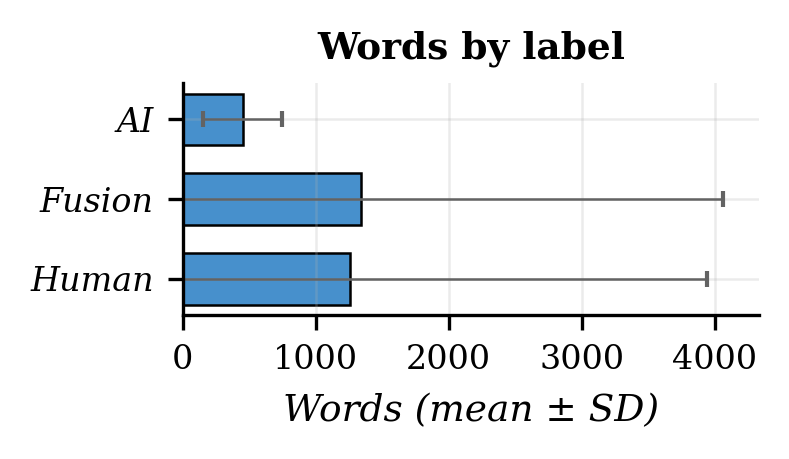

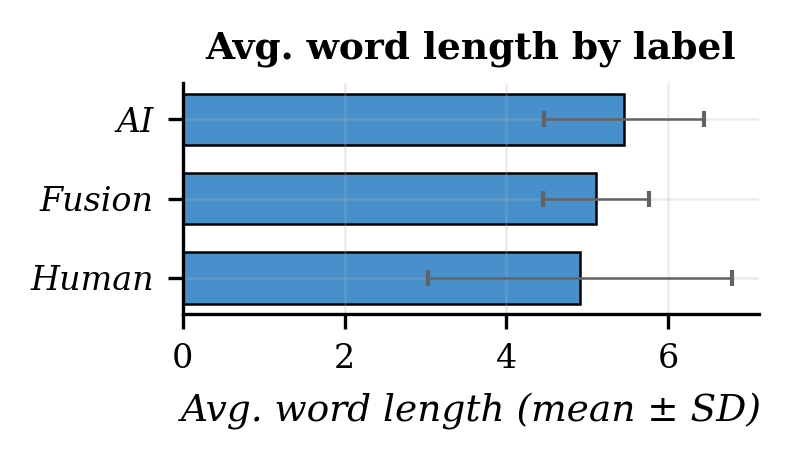

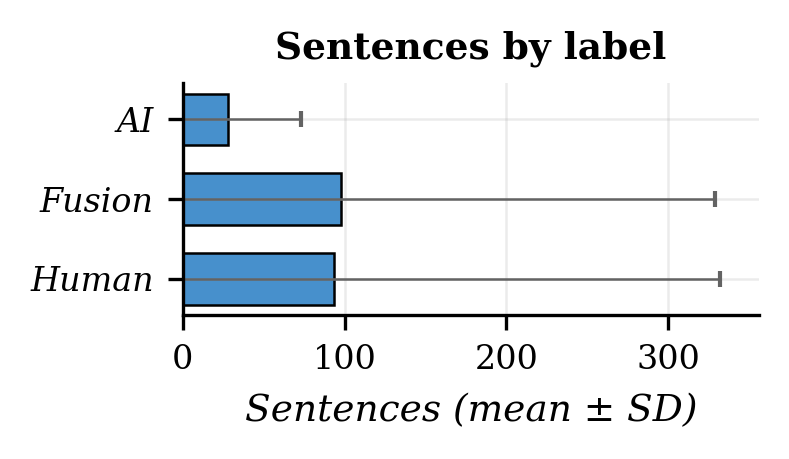

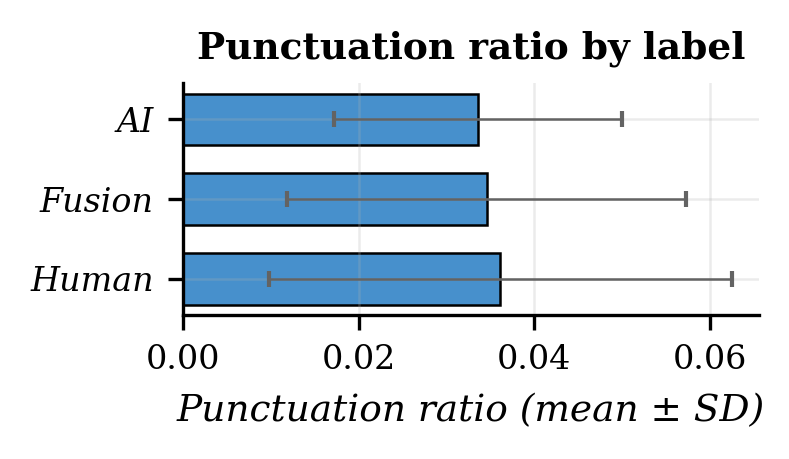

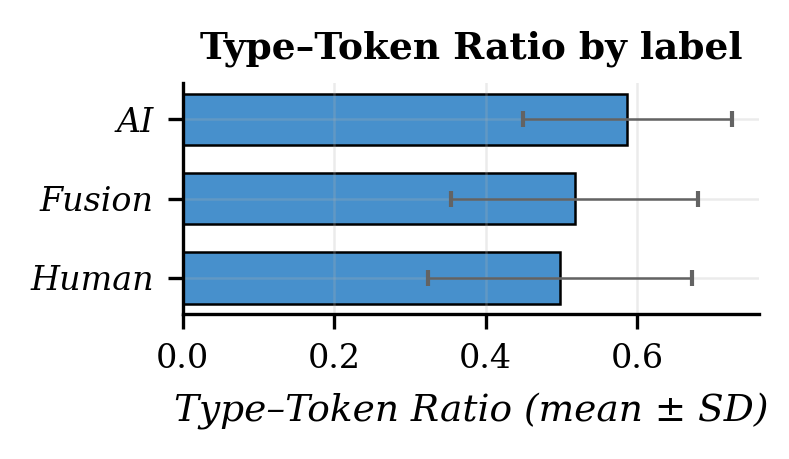

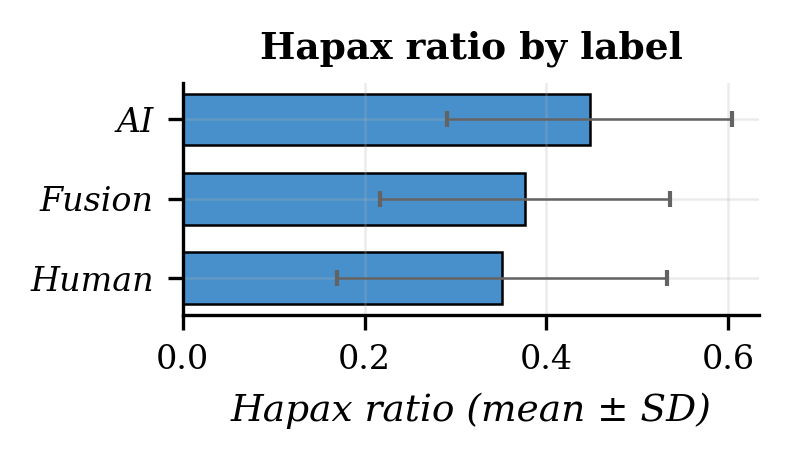

In [26]:
# 3.5 By Label
for m in KEY_METRICS:
    if f"{m}_mean" in metrics_by_label.columns:
        plot_group_metric_bar(
            metrics_by_label, "label", m,
            out_dir="figures",
            width="one",
            height=1.6,
            title=f"{prettify_metric_name(m)} by label",
            filename_stem=f"label_{m}"
        )